In [1]:
import cubewalkers as cw
import cupy as cp
from copy import deepcopy

In [2]:
IMPORT_RULES_FROM_FILES = True
cc_models_dir = './models/cell_collective/'
if IMPORT_RULES_FROM_FILES:
    from os import listdir
    
    sync_models = {}
    for fname in listdir(cc_models_dir):
        with open(cc_models_dir+fname) as rulefile:
            name = fname.strip('.txt')
            rules = rulefile.read()
            sync_models[name]=cw.Model(rules)
else:
    from cana.datasets.bio import load_all_cell_collective_models
    def cell_collective_models():
        return {BN.name:cw.Model(cw.conversions.network_rules_from_cana(BN)) 
                for BN in load_all_cell_collective_models()}
    sync_models = cell_collective_models()
    for name,model in sync_models.items():
        with open(cc_models_dir+name+'.txt','w') as rulefile:
            rulefile.write(model.rules)

total_models = len(sync_models)
async_models = deepcopy(sync_models)

In [15]:
def hamming_distance_cell_coll(models, sync=True, T_synch=10, W=10000):
    hamming_distances = {}
    for model_idx, (model_name, model) in enumerate(models.items()):
        N = model.n_variables
        
        if sync:
            print(f"Calculating Hamming distances in synchronous for {model_name} (T={T_synch},{N=},{W=}). . .")
            model.n_time_steps = T_synch
            model.n_walkers = W // N
            derrida_synch = cp.zeros((model.n_time_steps+1))
            for node in model.vardict:
                di = model.dynamical_impact(source_var=node,maskfunction=cw.update_schemes.synchronous,threads_per_block=(16,16))
                di = cp.sum(di, axis=1)
                derrida_synch += di
            derrida_synch /= N
            hamming_distances[model_name] = derrida_synch
        else:
            print(f"Calculating Hamming distances in asynchronous for {model_name} (T={T_synch * N},{N=},{W=}). . .")
            model.n_time_steps = T_synch * N
            model.n_walkers = W // N
            derrida_asynch = cp.zeros((model.n_time_steps+1))
            for node in model.vardict:
                di = model.dynamical_impact(source_var=node,maskfunction=cw.update_schemes.asynchronous,threads_per_block=(16,16))
                di = cp.sum(di, axis=1)
                derrida_asynch += di
            derrida_asynch /= N
            hamming_distances[model_name] = derrida_asynch
        print(f"Progress: {(model_idx+1)}/{total_models}")
    return hamming_distances

In [14]:
sync_hamming_distances = hamming_distance_cell_coll(sync_models,sync=True)

Calculating Hamming distances in synchronous for Apoptosis Network (T=10,N=41,W=10000). . .
Progress: 1/74
Calculating Hamming distances in synchronous for Arabidopsis thaliana Cell Cycle (T=10,N=14,W=10000). . .
Progress: 2/74
Calculating Hamming distances in synchronous for Aurora Kinase A in Neuroblastoma (T=10,N=23,W=10000). . .
Progress: 3/74
Calculating Hamming distances in synchronous for B bronchiseptica and T retortaeformis coinfection (T=10,N=53,W=10000). . .
Progress: 4/74
Calculating Hamming distances in synchronous for B cell differentiation (T=10,N=22,W=10000). . .
Progress: 5/74
Calculating Hamming distances in synchronous for Bordetella bronchiseptica (T=10,N=33,W=10000). . .
Progress: 6/74
Calculating Hamming distances in synchronous for Bortezomib Responses in U266 Human Myeloma Cells (T=10,N=67,W=10000). . .
Progress: 7/74
Calculating Hamming distances in synchronous for BT474 Breast Cell Line Long-term ErbB Network (T=10,N=25,W=10000). . .
Progress: 8/74
Calculating

Progress: 66/74
Calculating Hamming distances in synchronous for TOL Regulatory Network (T=10,N=24,W=10000). . .
Progress: 67/74
Calculating Hamming distances in synchronous for Toll Pathway of Drosophila Signaling Pathway (T=10,N=11,W=10000). . .
Progress: 68/74
Calculating Hamming distances in synchronous for Treatment of Castration-Resistant Prostate Cancer (T=10,N=42,W=10000). . .
Progress: 69/74
Calculating Hamming distances in synchronous for Trichostrongylus retortaeformis (T=10,N=26,W=10000). . .
Progress: 70/74
Calculating Hamming distances in synchronous for Tumour Cell Invasion and Migration (T=10,N=32,W=10000). . .
Progress: 71/74
Calculating Hamming distances in synchronous for VEGF Pathway of Drosophila Signaling Pathway (T=10,N=18,W=10000). . .
Progress: 72/74
Calculating Hamming distances in synchronous for Wg Pathway of Drosophila Signalling Pathways (T=10,N=26,W=10000). . .
Progress: 73/74
Calculating Hamming distances in synchronous for Yeast Apoptosis (T=10,N=73,W=1

In [21]:
async_hamming_distances = hamming_distance_cell_coll(sync_models,sync=False)

Calculating Hamming distances in asynchronous for Apoptosis Network (T=410,N=41,W=10000). . .
Progress: 1/74
Calculating Hamming distances in asynchronous for Arabidopsis thaliana Cell Cycle (T=140,N=14,W=10000). . .
Progress: 2/74
Calculating Hamming distances in asynchronous for Aurora Kinase A in Neuroblastoma (T=230,N=23,W=10000). . .
Progress: 3/74
Calculating Hamming distances in asynchronous for B bronchiseptica and T retortaeformis coinfection (T=530,N=53,W=10000). . .
Progress: 4/74
Calculating Hamming distances in asynchronous for B cell differentiation (T=220,N=22,W=10000). . .
Progress: 5/74
Calculating Hamming distances in asynchronous for Bordetella bronchiseptica (T=330,N=33,W=10000). . .
Progress: 6/74
Calculating Hamming distances in asynchronous for Bortezomib Responses in U266 Human Myeloma Cells (T=670,N=67,W=10000). . .
Progress: 7/74
Calculating Hamming distances in asynchronous for BT474 Breast Cell Line Long-term ErbB Network (T=250,N=25,W=10000). . .
Progress: 

Progress: 64/74
Calculating Hamming distances in asynchronous for T-LGL Survival Network 2011 Reduced Network (T=180,N=18,W=10000). . .
Progress: 65/74
Calculating Hamming distances in asynchronous for T-LGL Survival Network 2011 (T=600,N=60,W=10000). . .
Progress: 66/74
Calculating Hamming distances in asynchronous for TOL Regulatory Network (T=240,N=24,W=10000). . .
Progress: 67/74
Calculating Hamming distances in asynchronous for Toll Pathway of Drosophila Signaling Pathway (T=110,N=11,W=10000). . .
Progress: 68/74
Calculating Hamming distances in asynchronous for Treatment of Castration-Resistant Prostate Cancer (T=420,N=42,W=10000). . .
Progress: 69/74
Calculating Hamming distances in asynchronous for Trichostrongylus retortaeformis (T=260,N=26,W=10000). . .
Progress: 70/74
Calculating Hamming distances in asynchronous for Tumour Cell Invasion and Migration (T=320,N=32,W=10000). . .
Progress: 71/74
Calculating Hamming distances in asynchronous for VEGF Pathway of Drosophila Signal

In [22]:
with open('./data/hamming_distances.csv','w') as f:
    for model_name in sorted(sync_models):
        shd = ','.join(map(lambda x: str(cp.round(x,3)),sync_hamming_distances[model_name]))
        ahd = ','.join(map(lambda x: str(cp.round(x,3)),async_hamming_distances[model_name]))
        f.write(f'{model_name},synchronous,{shd}\n')
        f.write(f'{model_name},asynchronous,{ahd}\n')

In [23]:
models_to_plot = []
for model_name in sorted(sync_models):
    shd = sync_hamming_distances[model_name]
    ahd = async_hamming_distances[model_name]
    if any(value > 1.1 for value in shd) and any(value < 0.9 for value in shd):
        models_to_plot.append(model_name)
    elif any(value > 1.1 for value in ahd) and any(value < 0.9 for value in ahd):
        models_to_plot.append(model_name)

print(models_to_plot)

['FA BRCA pathway', 'Lymphoid and myeloid cell specification and transdifferentiation', 'Mammalian Cell Cycle 2006', 'Tumour Cell Invasion and Migration']


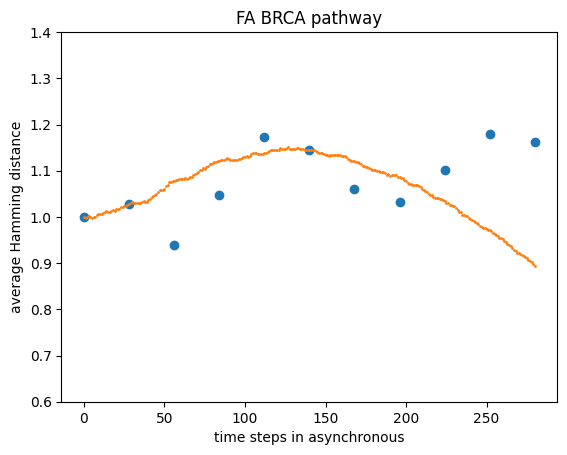

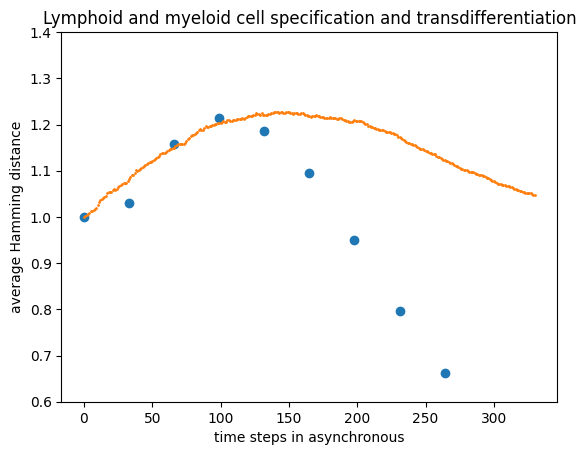

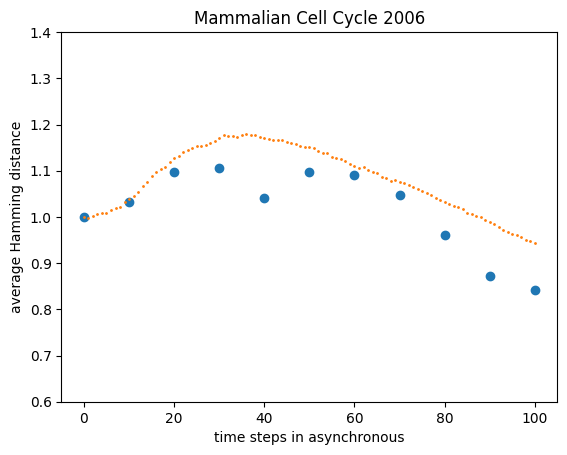

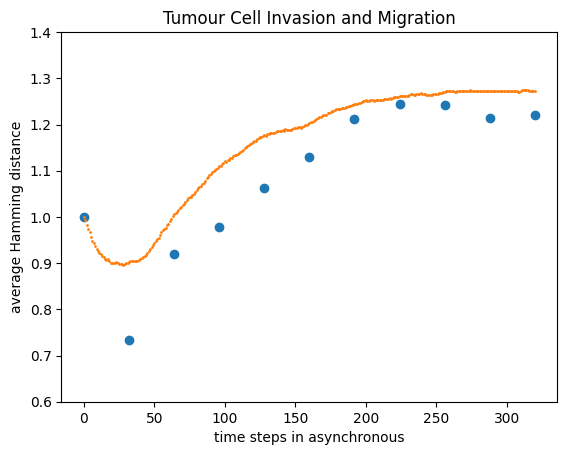

In [46]:
import matplotlib.pyplot as plt
import numpy as np

for model in models_to_plot:
    x2 = list(range(len(async_hamming_distances[model])))
    x1 = x2[::len(async_hamming_distances[model])//10]
    y = [float(i) for i in sync_hamming_distances[model]]
    z = [float(i) for i in async_hamming_distances[model]]

    plt.scatter(x1, y)
    plt.scatter(x2, z,s=1)
    plt.title(model)
    plt.xlabel('time steps in asynchronous')
    plt.ylabel('average Hamming distance')
    plt.axis([None, None, 0.6, 1.4])
    plt.show()